In [ ]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [279]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import iexfinance.stocks as stocks
import tools
import os
from params import TOKEN

plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["lines.linewidth"] = 2

PROJECT_PATH = "\\".join(os.getcwd().split("\\")[:-1])
DATA_PATH = os.path.join(PROJECT_PATH, "data")

<IPython.core.display.Javascript object>

#### Scrape tickers and get company information
Note: you will need an account to get a token for IEX API

In [54]:
table = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
tickers = table['Symbol'].tolist()

In [220]:
def get_info(tickers):
    return stocks.Stock(tickers, token=TOKEN).get_company()

def process_info(info):
    info["industry"] = info["industry"].str[:80] + "..."
    info["industry"] = info["industry"].replace("...", "UNKNOWN")
    return info

info = pd.concat(
    [get_info(tickers[i : i + 100]) for i in range(0, len(tickers), 100)]
)
info = process_info(info)
info.to_pickle(os.path.join(DATA_PATH, "sp500_info.p"))

<IPython.core.display.Javascript object>

#### Get returns of Finance companies

In [235]:
companies = info[info["tags"].apply(",".join).str.contains("Finance")]
tickers = companies["symbol"].tolist()

start = "2012-01-01"
end = "2020-12-29"
data = {}
for raw_ticker in tickers:
    ticker = raw_ticker.split(".")[0]
    ticker_object = yf.Ticker(ticker)
    data[ticker] = ticker_object.history(start=start, end=end)["Close"]
    print(ticker, end=" ")

AFL ARE ALL AXP AIG AMT AMP ANTM AON AJG AIZ AVB BAC BK BRK BLK BXP COF CBOE CBRE CNC SCHW CB CI CINF C CFG CME CMA CCI DLR DFS DRE EQIX EQR ESS RE EXR FRT FITB FRC BEN GL GS HIG PEAK HST HBAN INFO ICE IVZ IRM JPM KEY KIM LNC L MTB MKTX MMC MA MET MAA MS MSCI NDAQ NTRS PBCT PNC PFG PGR PLD PRU PSA RJF O REG RF SPGI SBAC SPG SLG STT SIVB SYF TROW TRV TFC UDR USB UNH URI UNM VTR VRSK V VNO WRB WFC WELL WU WY WLTW ZION 

<IPython.core.display.Javascript object>

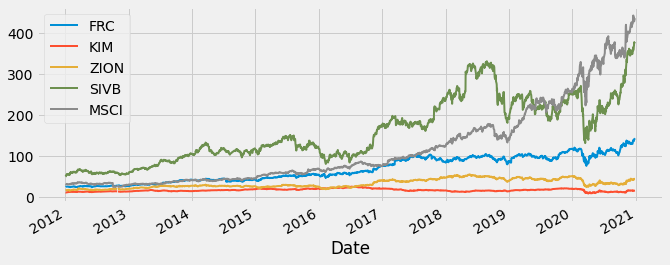

<IPython.core.display.Javascript object>

In [288]:
prices = pd.DataFrame(data)
prices.sample(5, axis=1).plot()
returns = prices.pct_change().dropna()

#### Scrape H1B filings from h1bdata.info

In [328]:
functions = ["ANALYTICS", "DATA+SCI", "DATA+ANA", "STATIST", "MACHINE+LEARNING"]
levels = ["JUNIOR", "SENIOR", "LEAD", "STAFF", "MANAGER", "CHIEF", "PRINCIPAL"]
combos = ["+".join([l, f]) for l in levels for f in functions]
search_terms = functions + combos

tables = []
for term in search_terms[:]:
    print(term, end="")
    for year in range(2012, 2021):
        url = "https://h1bdata.info/index.php?em=&job={}&city=&year={}"
        table = pd.read_html(url.format(term, year))[0]
        tables.append(table)
        print(".", end="")

filings = pd.concat(tables)
filings.to_pickle(os.path.join(DATA_PATH, "h1b_filings.p"))
filings = filings.dropna()
filings = filings[filings["CASE STATUS"] == "CERTIFIED"]
filings.head()

ANALYTICS.........DATA+SCI.........DATA+ANA.........STATIST.........MACHINE+LEARNING.........JUNIOR+ANALYTICS.........JUNIOR+DATA+SCI.........JUNIOR+DATA+ANA.........JUNIOR+STATIST.........JUNIOR+MACHINE+LEARNING.........SENIOR+ANALYTICS.........SENIOR+DATA+SCI.........SENIOR+DATA+ANA.........SENIOR+STATIST.........SENIOR+MACHINE+LEARNING.........LEAD+ANALYTICS.........LEAD+DATA+SCI.........LEAD+DATA+ANA.........LEAD+STATIST.........LEAD+MACHINE+LEARNING.........STAFF+ANALYTICS.........STAFF+DATA+SCI.........STAFF+DATA+ANA.........STAFF+STATIST.........STAFF+MACHINE+LEARNING.........MANAGER+ANALYTICS.........MANAGER+DATA+SCI.........MANAGER+DATA+ANA.........MANAGER+STATIST.........MANAGER+MACHINE+LEARNING.........CHIEF+ANALYTICS.........CHIEF+DATA+SCI.........CHIEF+DATA+ANA.........CHIEF+STATIST.........CHIEF+MACHINE+LEARNING.........PRINCIPAL+ANALYTICS.........PRINCIPAL+DATA+SCI.........PRINCIPAL+DATA+ANA.........PRINCIPAL+STATIST.........PRINCIPAL+MACHINE+LEARNING.........

,EMPLOYER,JOB TITLE,BASE SALARY,LOCATION,SUBMIT DATE,START DATE,CASE STATUS
0,GSD&M IDEA CITY LLC,ANALYTICS MANAGER,73861,"AUSTIN, TX",03/09/2012,03/12/2012,WITHDRAWN
0,MEDIACOM WORLDWIDE INC,ANALYTICS DIRECTOR,145000,"NEW YORK, NY",05/22/2013,08/01/2013,WITHDRAWN
1,UBER TECHNOLOGIES INC,ANALYTICS ENGINEER,80000,"SAN FRANCISCO, CA",03/21/2013,09/20/2013,WITHDRAWN
2,KAYAK SOFTWARE CORPORATION,ANALYTICS ENGINEER,112000,"CONCORD, MA",02/27/2013,07/26/2013,WITHDRAWN
0,KIEWIT CORPORATION,ANALYTICS & REPORTING DEVELOPER SAP BW BPC,93000,"OMAHA, NE",10/15/2014,10/22/2014,CERTIFIED


<IPython.core.display.Javascript object>

#### Match company names

<IPython.core.display.Javascript object>

In [344]:
from tools.string import standardize_name, StringComparer

iex_names = companies["companyName"].apply(standardize_name).tolist()
h1b_names = filings["EMPLOYER"].apply(standardize_name).tolist()
print(iex_names[:5])
print(h1b_names[:5])

sc = StringComparer(h1b_names, iex_names)
matches = sc.get_matches()

['aflac', 'alexandria real estate equities', 'allstate corp', 'american express', 'american international group']
['gsd m idea city', 'mediacom worldwide', 'uber technologies', 'kayak software corporation', 'kiewit corporation']
StringComparer 1% completed - 0.00s
StringComparer 10% completed - 0.03s
StringComparer 20% completed - 0.07s
StringComparer 30% completed - 0.11s
StringComparer 40% completed - 0.16s
StringComparer 50% completed - 0.20s
StringComparer 60% completed - 0.27s
StringComparer 70% completed - 0.32s
StringComparer 80% completed - 0.38s
StringComparer 90% completed - 0.44s
StringComparer 100% completed - 0.50s


<IPython.core.display.Javascript object>

In [371]:
h1b_raw = filings["EMPLOYER"].drop_duplicates()
h1b_raw2clean = dict(zip(h1b_raw, h1b_raw.apply(standardize_name)))
iex_raw = info["companyName"].drop_duplicates()
iex_raw2clean = dict(zip(iex_raw, iex_raw.apply(standardize_name)))
h1b2iex = matches.set_index("s")["t"].to_dict()
iex2ticker = info.set_index("companyName")["symbol"].to_dict()

_ = filings["EMPLOYER"]
_ = _.map(h1b_raw2clean)
_ = _.map(h1b2iex)
_ = _.map(iex_raw2clean)
_ = _.map(iex2ticker)
filings["TICKER"] = _

<IPython.core.display.Javascript object>

In [374]:
_ = filings["EMPLOYER"]
_ = _.map(h1b_raw2clean)
_ = _.map(h1b2iex)
# _ = _.map(iex_raw2clean)
_.dropna()

2                  jpmorgan chase
4                  jpmorgan chase
5                  jpmorgan chase
6                  jpmorgan chase
7                  jpmorgan chase
                 ...             
22    discover financial services
30                         anthem
4     discover financial services
52          lincoln national corp
0     discover financial services
Name: EMPLOYER, Length: 616, dtype: object

<IPython.core.display.Javascript object>